<h1><center><font size="25">Forecasting with LSTM models</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

<center><i>September, 2023</i></center>

**More about forecasting**

+ [Introduction to forecasting with skforecast](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)
+ [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM and CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html)
+ [Forecasting electricity demand with Python](https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html)
+ [Forecasting web traffic with machine learning and Python](https://www.cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html)
+ [Bitcoin price prediction with Python, when the past does not repeat itself](https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html)
+ [Prediction intervals in forecasting models](https://www.cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html)
+ [Intermittent demand forecasting with skforecast](https://www.cienciadedatos.net/documentos/py48-intermittent-demand-forecasting)

<p align="center"><img src='https://github.com/JoaquinAmatRodrigo/skforecast/raw/master/docs/img/banner-landing-page-skforecast.png'style="width: 600px"></p>

## Introdución


<p align="center"><img src='lstm1.png'style="width: 600px"></p>

## Librerías

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'/Users/fernandocarazo/Documents/git-repos/skforecast'

In [2]:
#!pip install tensorflow
#!pip install torch -f https://download.pytorch.org/whl/torch_stable.html
#!pip install pytorch-forecasting

In [3]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
# ==============================================================================
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler

# Tensorflow
# ==============================================================================
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Input, Reshape, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping


2023-10-18 20:42:58.919410: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Datos

In [4]:
# ---------------------------------------------------------------------------- #
#                               Downloading data                               #
# ---------------------------------------------------------------------------- #

url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
print(data.index.to_series().diff().dt.total_seconds().value_counts())
data = data.asfreq('H')
data = data.sort_index()
data = data.drop(columns=['workingday', "weather"])
data.head()

date_time
3600.0    17543
Name: count, dtype: int64


,holiday,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,
2011-01-01 00:00:00,0.0,9.84,14.395,81.0,0.0,16.0,1,0,5
2011-01-01 01:00:00,0.0,9.02,13.635,80.0,0.0,40.0,1,1,5
2011-01-01 02:00:00,0.0,9.02,13.635,80.0,0.0,32.0,1,2,5
2011-01-01 03:00:00,0.0,9.84,14.395,75.0,0.0,13.0,1,3,5
2011-01-01 04:00:00,0.0,9.84,14.395,75.0,0.0,1.0,1,4,5


In [5]:
# ---------------------------------------------------------------------------- #
#                          Split train-validation-test                         #
# ---------------------------------------------------------------------------- #

end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


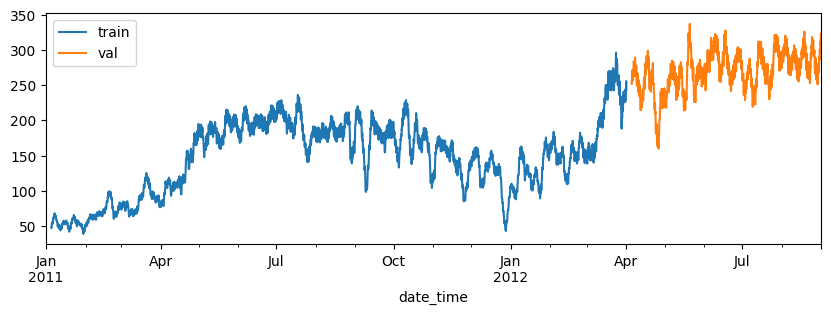

In [6]:
# ----------------------------------- Users ---------------------------------- #
fig, ax = plt.subplots(figsize=(10,3))
data_train[["users"]].rolling(100).mean().plot(ax=ax, label="train")
data_val[["users"]].rolling(100).mean().plot(ax=ax, label="val")
ax.legend(["train", "val"]) 

## Modelo LSTM con tensorflow-keras

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://www.tensorflow.org/tutorials/structured_data/time_series


We are working with a univariate series, so the number of features is one, for one variable.

The number of time steps as input is the number of lags used as predictors.

We almost always have multiple samples, therefore, the model will expect the input component of training data to have the dimensions or shape: [samples, timesteps, features]

# Multi-series, multi-step

In [9]:
levels = ["users", "temp", "hum"] # , 
lags = 12
steps = 5

# llevar el compile al create model

model = create_and_compile_model(
    series=data_train,
    lags=lags,
    steps=steps,
    levels=levels,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[128, 64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss= MeanSquaredError()
)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 9)]           0         
                                                                 
 lstm (LSTM)                 (None, 12, 100)           44000     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense_7 (Dense)             (None, 128)               6528      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 15)                495 

In [33]:
forecaster = ForecasterRnn(
    regressor=model, 
    levels=levels, 
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs":3,
        "batch_size":128,
        "callbacks":[EarlyStopping(monitor='val_loss', patience=10)],
        "series_val":data_val,
    },
)


In [34]:
forecaster.fit(data_train)

Epoch 1/3
86/86 [==============================] - 6s 65ms/step - loss: 0.0067 - val_loss: 0.0182
Epoch 2/3
86/86 [==============================] - 6s 65ms/step - loss: 0.0062 - val_loss: 0.0182
Epoch 3/3
86/86 [==============================] - 6s 68ms/step - loss: 0.0061 - val_loss: 0.0168


In [35]:
predictions = forecaster.predict(steps=[1,5], levels="users")
predictions

1/1 [==============================] - 0s 127ms/step


,users
2012-04-01 00:00:00,35.813541
2012-04-01 04:00:00,50.516945


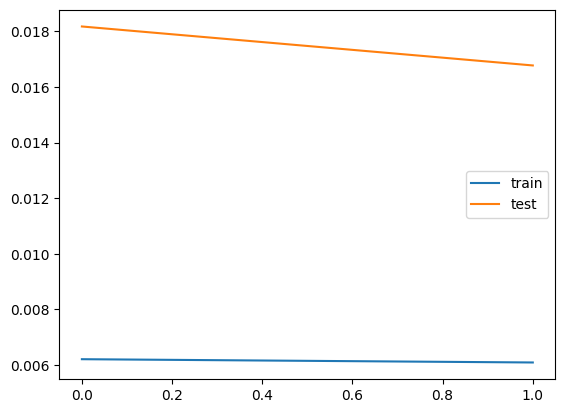

In [36]:
# ---------------------------------------------------------------------------- #
#                                 Plot history                                 #
# ---------------------------------------------------------------------------- #

def plot_history(history):
    plt.plot(history['loss'][1:], label='train')
    plt.plot(history['val_loss'][1:], label='test')
    plt.legend()
    plt.show()
    
plot_history(forecaster.history)
    

In [38]:
# ---------------------------------------------------------------------------- #
#                                    Predict                                   #
# ---------------------------------------------------------------------------- #

predictions = forecaster.predict()

1/1 [==============================] - 0s 36ms/step


In [39]:
predictions

,users,temp,hum
2012-04-01 00:00:00,35.813541,19.293367,70.031204
2012-04-01 01:00:00,24.108801,19.116962,69.924683
2012-04-01 02:00:00,6.712239,19.111334,70.863060
2012-04-01 03:00:00,17.947474,19.073238,71.195145
2012-04-01 04:00:00,50.516945,19.297346,71.832329


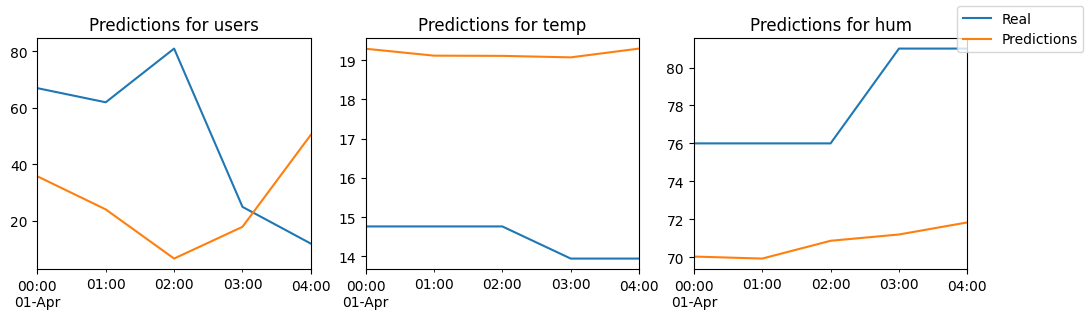

In [40]:
# ---------------------------------------------------------------------------- #
#                               Plot predictions                               #
# ---------------------------------------------------------------------------- #
fig, ax = plt.subplots(ncols=3, figsize=(12, 3) )
for i, ll in enumerate(levels):
    ax[i].set_title(f'Predictions for {ll}')
    data_val.loc[predictions.index, ll].plot(ax=ax[i], label="Real")
    predictions[ll].squeeze().plot(ax=ax[i], label="Predictions")
# fig.legend(["Real", "Predictions"])
fig.legend(["Real", "Predictions"])
plt.show()

# Backtesting

In [48]:
forecaster.levels

['users', 'temp', 'hum']

In [50]:
data_train.shape

(10944, 9)

In [53]:
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.steps,
    series=data_train,
    levels=forecaster.levels,
    initial_train_size=int(len(data_train)*0.95),
    metric="mean_squared_error",
    verbose=True
)

# series: pd.DataFrame,
# steps: int, # TODO lo falsearemos, no necesario
# metric: Union[str, Callable, list],
# initial_train_size: Optional[int]=None,
# fixed_train_size: bool=True,
# gap: int=0,
# allow_incomplete_fold: bool=True,
# levels: Optional[Union[str, list]]=None,
# exog: Optional[Union[pd.Series, pd.DataFrame]]=None,
# refit: Optional[Union[bool, int]]=False,
# interval: Optional[list]=None,
# n_boot: int=500,
# random_state: int=123,
# in_sample_residuals: bool=True,
# n_jobs: Optional[Union[int, str]]='auto',
# verbose: bool=False,
# show_progress: bool=True

Epoch 1/3
81/82 [============================>.] - ETA: 0s - loss: 0.0083

 11%|█         | 119/1095 [05:30<45:13,  2.78s/it]


82/82 [==============================] - 16s 99ms/step - loss: 0.0083 - val_loss: 0.0157
Epoch 2/3
82/82 [==============================] - 6s 70ms/step - loss: 0.0079 - val_loss: 0.0182
Epoch 3/3
82/82 [==============================] - 5s 66ms/step - loss: 0.0076 - val_loss: 0.0123
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10396
Number of observations used for backtesting: 548
    Number of folds: 110
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   2011-01-01 00:00:00 -- 2012-03-09 03:00:00  (n=10396)
    Validation: 2012-03-09 04:00:00 -- 2012-03-09 08:00:00  (n=5)
Fold: 1
    Training:   2011-01-01 00:00:00 -- 2012-03-09 03:00:00  (n=10396)
    Validation: 2012-03-09 09:00:00 -- 2012-03-09 13:00:00  (n=5)
Fold: 2
    Training:   2011-01-01 00:00:00 -- 2012-03-09 03:00:00 

  0%|          | 0/110 [00:00<?, ?it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn

1/1 [==============================] - 1s 986ms/step


  1%|          | 1/110 [00:01<02:30,  1.38s/it]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Forec

1/1 [==============================] - 0s 59ms/step


  2%|▏         | 2/110 [00:01<01:26,  1.25it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Forec

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 3/110 [00:02<01:02,  1.72it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Forec

1/1 [==============================] - 0s 62ms/step


  4%|▎         | 4/110 [00:02<00:53,  1.96it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Forec

1/1 [==============================] - 0s 75ms/step


  5%|▍         | 5/110 [00:02<00:51,  2.03it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Forec

1/1 [==============================] - 0s 165ms/step


  5%|▌         | 6/110 [00:03<00:54,  1.92it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Forec

1/1 [==============================] - 0s 54ms/step


  6%|▋         | 7/110 [00:04<00:53,  1.94it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Forec

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 8/110 [00:04<00:47,  2.15it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Forec

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 9/110 [00:04<00:43,  2.30it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Forec

1/1 [==============================] - 0s 56ms/step


  9%|▉         | 10/110 [00:05<00:43,  2.29it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 57ms/step


 10%|█         | 11/110 [00:05<00:40,  2.44it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 52ms/step


 11%|█         | 12/110 [00:05<00:37,  2.59it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 13/110 [00:06<00:37,  2.55it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 14/110 [00:06<00:36,  2.61it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 50ms/step


 14%|█▎        | 15/110 [00:07<00:35,  2.65it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 16/110 [00:07<00:35,  2.64it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 59ms/step


 15%|█▌        | 17/110 [00:07<00:34,  2.71it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 49ms/step


 16%|█▋        | 18/110 [00:08<00:37,  2.45it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 58ms/step


 17%|█▋        | 19/110 [00:08<00:36,  2.50it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 20/110 [00:08<00:34,  2.64it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 21/110 [00:09<00:31,  2.79it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 69ms/step


 20%|██        | 22/110 [00:09<00:31,  2.81it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 50ms/step


 21%|██        | 23/110 [00:09<00:30,  2.87it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 24/110 [00:10<00:30,  2.84it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 25/110 [00:10<00:28,  2.93it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 49ms/step


 24%|██▎       | 26/110 [00:10<00:28,  2.94it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 146ms/step


 25%|██▍       | 27/110 [00:11<00:31,  2.66it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 28/110 [00:11<00:28,  2.85it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 29/110 [00:12<00:27,  2.99it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 30/110 [00:12<00:26,  3.01it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 31/110 [00:12<00:25,  3.15it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 32/110 [00:12<00:24,  3.20it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 44ms/step


 30%|███       | 33/110 [00:13<00:23,  3.21it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 52ms/step


 31%|███       | 34/110 [00:13<00:23,  3.19it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 35/110 [00:13<00:23,  3.24it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 36/110 [00:14<00:22,  3.31it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 51ms/step


 34%|███▎      | 37/110 [00:14<00:22,  3.19it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 38/110 [00:14<00:25,  2.85it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 39/110 [00:15<00:24,  2.92it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 40/110 [00:15<00:22,  3.05it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 41/110 [00:15<00:22,  3.13it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 42/110 [00:16<00:21,  3.20it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 43/110 [00:16<00:22,  3.01it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 44ms/step


 40%|████      | 44/110 [00:16<00:23,  2.84it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 37ms/step


 41%|████      | 45/110 [00:17<00:21,  3.05it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 126ms/step


 42%|████▏     | 46/110 [00:17<00:23,  2.78it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 47/110 [00:17<00:21,  2.88it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 58ms/step


 44%|████▎     | 48/110 [00:18<00:21,  2.91it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 49/110 [00:18<00:21,  2.82it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 50/110 [00:19<00:22,  2.69it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 46ms/step


 46%|████▋     | 51/110 [00:19<00:21,  2.72it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 52/110 [00:19<00:23,  2.52it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 89ms/step


 48%|████▊     | 53/110 [00:20<00:23,  2.39it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 49ms/step


 49%|████▉     | 54/110 [00:20<00:23,  2.39it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 55/110 [00:21<00:25,  2.18it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 56/110 [00:21<00:23,  2.32it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 57/110 [00:22<00:21,  2.43it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 58/110 [00:22<00:20,  2.54it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 75ms/step


 54%|█████▎    | 59/110 [00:22<00:20,  2.54it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 60ms/step


 55%|█████▍    | 60/110 [00:23<00:20,  2.49it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 61/110 [00:23<00:19,  2.54it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 55ms/step


 56%|█████▋    | 62/110 [00:23<00:18,  2.56it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 63/110 [00:24<00:19,  2.44it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 64/110 [00:24<00:17,  2.61it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 65/110 [00:25<00:16,  2.77it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 66/110 [00:25<00:15,  2.77it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 67/110 [00:25<00:15,  2.86it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 68/110 [00:26<00:15,  2.77it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 69/110 [00:26<00:15,  2.63it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 70/110 [00:26<00:15,  2.57it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 54ms/step


 65%|██████▍   | 71/110 [00:27<00:14,  2.64it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 72/110 [00:27<00:15,  2.51it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 53ms/step


 66%|██████▋   | 73/110 [00:28<00:13,  2.66it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 74/110 [00:28<00:14,  2.52it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 75/110 [00:28<00:12,  2.71it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 76/110 [00:29<00:11,  2.85it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 77/110 [00:29<00:11,  2.91it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 78/110 [00:29<00:10,  2.93it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 79/110 [00:30<00:10,  2.95it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 80/110 [00:30<00:11,  2.61it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 51ms/step


 74%|███████▎  | 81/110 [00:30<00:10,  2.72it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 82/110 [00:31<00:10,  2.74it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 83/110 [00:31<00:09,  2.78it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 52ms/step


 76%|███████▋  | 84/110 [00:31<00:09,  2.83it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 85/110 [00:32<00:08,  2.89it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 86/110 [00:32<00:08,  2.88it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 87/110 [00:32<00:07,  2.96it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 54ms/step


 80%|████████  | 88/110 [00:33<00:07,  2.89it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 89/110 [00:33<00:07,  2.82it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 90/110 [00:34<00:07,  2.58it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 91/110 [00:34<00:06,  2.76it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 92/110 [00:34<00:06,  2.91it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 93/110 [00:35<00:05,  2.97it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 94/110 [00:35<00:05,  2.95it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 58ms/step


 86%|████████▋ | 95/110 [00:35<00:05,  2.82it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 96/110 [00:36<00:04,  2.93it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 97/110 [00:36<00:04,  3.00it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 98/110 [00:36<00:04,  2.99it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 99/110 [00:37<00:04,  2.63it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/Fore

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 100/110 [00:37<00:03,  2.69it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/For

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 101/110 [00:38<00:03,  2.67it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/For

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 102/110 [00:38<00:02,  2.68it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/For

1/1 [==============================] - 0s 54ms/step


 94%|█████████▎| 103/110 [00:38<00:02,  2.67it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/For

1/1 [==============================] - 0s 48ms/step


 95%|█████████▍| 104/110 [00:39<00:02,  2.71it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/For

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 105/110 [00:39<00:01,  2.74it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/For

1/1 [==============================] - 0s 51ms/step


 96%|█████████▋| 106/110 [00:39<00:01,  2.78it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/For

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 107/110 [00:40<00:01,  2.55it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/For

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 108/110 [00:40<00:00,  2.50it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/For

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 109/110 [00:41<00:00,  2.40it/s]/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_window[serie_name] = last_window_values
/Users/fernandocarazo/Documents/git-repos/skforecast/skforecast/ForecasterRnn/For

1/1 [==============================] - 0s 46ms/step


100%|██████████| 110/110 [00:41<00:00,  2.65it/s]


In [54]:
metrics

,levels,mean_squared_error
0,users,42620.024404
1,temp,17.772548
2,hum,410.760138


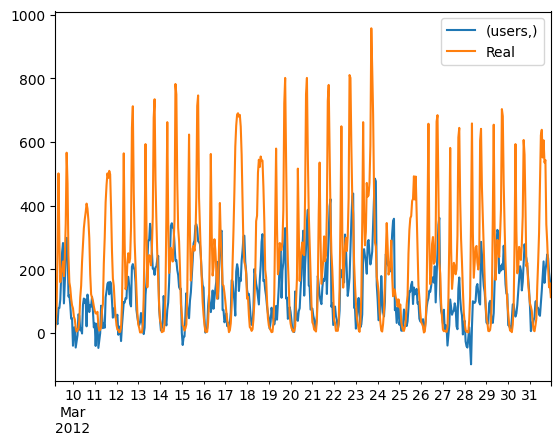

In [59]:
predictions["users"].plot(label="Predictions")
data_train.loc[predictions.index,"users"].plot(label="Real")
plt.legend()

## Información de sesión

In [21]:
import session_info
session_info.show(html=False)

-----
keras               2.13.1
matplotlib          3.7.3
numpy               1.24.3
pandas              2.0.3
seaborn             0.12.2
session_info        1.0.0
skforecast          0.10.0
sklearn             1.3.0
tensorflow          2.13.0
-----
IPython             8.15.0
jupyter_client      8.3.1
jupyter_core        5.3.1
-----
Python 3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]
macOS-10.16-x86_64-i386-64bit
-----
Session information updated at 2023-10-18 15:41


# Dev

## Bibliografía
<br>

Linear Models with R by Julian J.Faraway [libro](https://www.amazon.es/gp/product/1439887330/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1439887330&linkId=e9ca62e854567fb3f9d0ea044f084b11)

OpenIntro Statistics: Fourth Edition by David Diez, Mine Çetinkaya-Rundel, Christopher Barr [libro](https://www.amazon.es/gp/product/1943450072/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1943450072&linkId=a8b49fab17a559d33901ee804a9b5737)

Introduction to Machine Learning with Python: A Guide for Data Scientists [libro](https://www.amazon.es/gp/product/1449369413/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1449369413&linkId=e07f892d9e2c458e8144303901ea9580)

Points of Significance: Association, correlation and causation. Naomi Altman & Martin Krzywinski Nature Methods

https://en.wikipedia.org/wiki/Co



In [22]:
%%html
<style>
.text_cell_render p {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 1.15em
}

div.admonition.note {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 15px;
}


#notebook-container {
    background-color: #fcfcfc;
}

div.inner_cell {
    margin-right: 5%;
}

.output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
}

.rendered_html code {
    background-color: #f2f2f2;
    font-family: monospace;
    color: #a20505;
    font-size: 15px;
    padding: 1px 1px;
    border: solid;
    border-color: darkgray;
    border-width: thin;
}

.rendered_html h1 {
    padding-top: 50px;
}

.rendered_html h2 {
    font-size: 30px;
    margin-top: 0;
    font-size: 2.488em;
}

.rendered_html h3 {
    font-size: 25px;
}

.rendered_html h4 {
    font-size: 20px;
}

</style>

**¿Cómo citar este documento?**

<p style="text-align:left"><font size="3" color="#555">
TITULO DEL DOCUMENTO by AUTOR, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/pystats05-correlacion-lineal-python.html

    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by AUTOR is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.